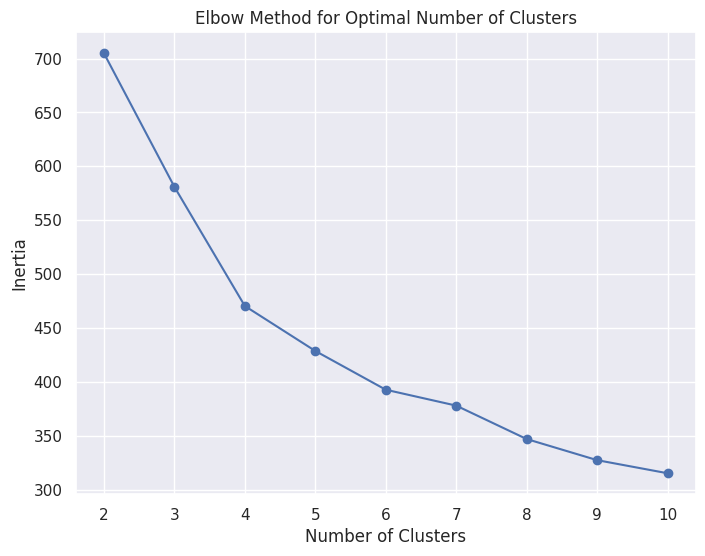

Number of Clusters: 3
Davies-Bouldin Index: 1.40


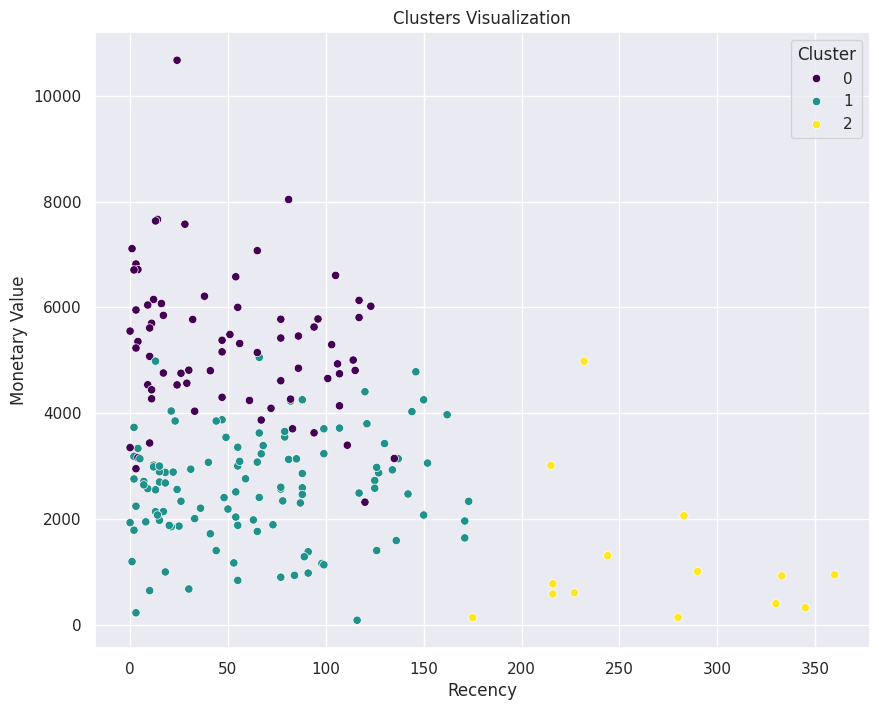


Cluster Statistics:
             Recency  Frequency  MonetaryValue      Tenure
Cluster                                                  
0         51.430556   7.250000    5286.871944  571.055556
1         64.203540   4.008850    2585.603363  567.061404
2        267.571429   1.785714    1226.257143  412.000000

Cluster Counts:
 Cluster
1    114
0     72
2     14
Name: count, dtype: int64


In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Loading datasets
transactions_df = pd.read_csv('Transactions.csv')
customers_df = pd.read_csv('Customers.csv')

# Data Cleaning and Preprocessing
def preprocess_data(transactions_df, customers_df):
    # Convert transaction date to datetime and extract relevant features
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    transactions_df['TransactionMonth'] = transactions_df['TransactionDate'].dt.month
    transactions_df['TransactionDayOfWeek'] = transactions_df['TransactionDate'].dt.dayofweek
    transactions_df['TransactionHour'] = transactions_df['TransactionDate'].dt.hour
    transactions_df['TransactionDayOfMonth'] = transactions_df['TransactionDate'].dt.day

    # Calculate recency, frequency, and monetary value
    rfm_df = transactions_df.groupby('CustomerID').agg({
        'TransactionDate': lambda date: (transactions_df['TransactionDate'].max() - date.max()).days,
        'TransactionID': 'count',
        'TotalValue': 'sum'
    })
    rfm_df.rename(columns={'TransactionDate': 'Recency',
                           'TransactionID': 'Frequency',
                           'TotalValue': 'MonetaryValue'}, inplace=True)


    merged_df = pd.merge(customers_df, rfm_df, on='CustomerID', how='left')

    merged_df['SignupDate'] = pd.to_datetime(merged_df['SignupDate'])
    merged_df['Tenure'] = (pd.to_datetime('today') - merged_df['SignupDate']).dt.days
       merged_df = merged_df.drop(columns=['CustomerName', 'SignupDate'])

    return merged_df

merged_df = preprocess_data(transactions_df, customers_df)

numerical_features = ['Recency', 'Frequency', 'MonetaryValue', 'Tenure']
categorical_features = ['Region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

preprocessor_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Process data
processed_data = preprocessor_pipeline.fit_transform(merged_df)

# Determine optimal number of clusters using the Elbow Method with inertia
inertia_values = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 'auto')
    kmeans.fit(processed_data)
    inertia_values.append(kmeans.inertia_)

# Ploting the elbow method results
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia_values, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()


optimal_n_clusters = 3  # Adjusted after Elbow Plot analysis

kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init = 'auto')
merged_df['Cluster'] = kmeans.fit_predict(processed_data)

db_index = davies_bouldin_score(processed_data, merged_df['Cluster'])

print(f"Number of Clusters: {optimal_n_clusters}")
print(f"Davies-Bouldin Index: {db_index:.2f}")

plt.figure(figsize=(10, 8))
sns.scatterplot(x='Recency', y='MonetaryValue', hue='Cluster', data=merged_df, palette='viridis')
plt.title('Clusters Visualization')
plt.xlabel('Recency')
plt.ylabel('Monetary Value')
plt.show()

cluster_stats = merged_df.groupby('Cluster')[numerical_features].mean()
print("\nCluster Statistics:\n", cluster_stats)

# Cluster counts
cluster_counts = merged_df['Cluster'].value_counts()
print("\nCluster Counts:\n", cluster_counts)